#### Author:
Simon Hackl, 04.03.2021

Integrative Transcriptomics (IBMI), University Tübingen

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to analyze the results of the `S7_assemblyEvaluation.sh` script regarding the assemblies with sub sampled reads of the CFT073 set. In order to re-run this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches

import os

import warnings # In order to ignore matplotlib deprecated warnings.
warnings.filterwarnings( "ignore" )
                        
from matplotlib.lines import Line2D

In [2]:
"""
The following code is based on https://jwalton.info/Embed-Publication-Matplotlib-Latex/ 
and is used to format generated plots in LaTeX style.
"""

plt.style.use('default')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

def set_size(width, height=False, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height :
        fig_height_in = height * fraction * inches_per_pt
    else :
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

####  Visualizing features from Quast reports of sub sample assemblies:

In the following, methods to visualize selected metrics of the `Quast` reports regarding the sub-sample assemblies are defined. The methods will allow to visualize a sub selection of the metrics from Quast report.tsv files for a sub selection of assemblers in a grid style. The visualization will be split into two columns of sub plots supporting different ranges of the sub sample detph of coverage in order to account for a wide value range between high and low sub sample depth of coverage runs. Each row will represent one selected metric.

In [9]:
def getFeature( feature, assembler, dataFrames ) :
    ''' Returns a list of the values of one feature of a `Quast` report of one assembler.
    
    Parameters
    ----------
    feature : str
        Specifies the feature of the Quast report for which the values are returned.
    assembler : str
        Specifies the assembler for which the values are returned.
    dataFrames : dict
        A dictionary containing panda.DataFrame objects accessible via the respective coverage of the
        read sub sample for which the report was calculated. Each dataframe should contain the features as rows
        and assemblers as columns.
        
    Returns
    -------
    : list
        A list containing the values of the specified feature from the Quast report of 
        the specified assembler for each sub sample coverage.
    '''
    # To access the specified feature, the passed rows referring to this feature of each dataframe
    # is merged in one new dataframe.
    keys = list( dataFrames.keys( ) )
    dataFrameMerged = pd.concat( [ dataFrames[ k ].loc[ feature ] for k in keys ], axis=1 )
    dataFrameMerged.columns = keys
    # Quast reports detected genomic features as complete and partly detected genomic features.
    # Therefore, if this feature is passed the contained values have to be parsed first to report
    # only complete features.
    if not assembler in dataFrameMerged.index :
        return [ float( np.nan ) ] * 7
        
    elif feature == "# genomic features" :
        complete = [ ]
        partly = [ ]
        for i in dataFrameMerged.loc[ assembler ].tolist( ) :
            if type( i ) == str and i != "nan" :
                completeGenes, partlyGenes = i.split( "+" )
                completeGenes = float( completeGenes.strip( ) )
                partlyGenes = float( partlyGenes.strip( "part" ).strip( ) )
                complete.append( completeGenes )
                partly.append( partlyGenes )
            else :
                complete.append( float( "nan" ) )
                partly.append( float( "nan" ) )
        return complete
    else :
        return [ float( i ) if not i == "-" else float( np.nan ) for i in dataFrameMerged.loc[ assembler ].tolist( ) ]

In [3]:
def plotFeatures( features, assemblers, dataFrames1, dataFrames2, genomeFeatureCount, markers = False, colors = False, assemblerNames = False,
                 title = "", ylabels = False, xlabel = "depth of coverage", altXticks1 = False, altXticks2 = False ) :
    ''' Visualizes the values returned by the `getFeature` method in two columns. One sub plot per passed feature is 
    generated in each row. The values returned for specified assemblers1 are plotted in the first, left column,
    the values returned for specified assemblers2 are plotted in the second, right column.
    
    Parameters
    ----------
    features: list
        A list of strings specifying Quast report features. These features should be named exactly as in the
        Quast report.
    assemblers1: list
        A list of strings specifying assemblers to visualized on the first column. These assemblers should be named exactly as in the
        Quast report. 
    dataFrames: dict
        A dictionary containing panda.DataFrame objects accessible via the respective coverage of the
        read sub sample for which the report was calculated. Each dataframe should contain the features as rows
        and assemblers as columns.
    dataFrames: dict
        ...
    genomeFeatureCount: int
        The number of reference genomic features of the sample for which the Quast reports were calculated.
        The value is used to report the number of genomic features as percentage relative to the total number
        of reference featrues.
    linewidth: False or float
        If set to False, the linewidht is computed as 0.05 * size. If a float is specified this value is used.
        Default is False
    markers: False or dictionary
         If set to False, the markers will be drawn as dots. If a dictionary is passed it should contain the passed
        assemblers as keys and each should refer to a pyplot marker name. Default is False.
    colors: False or dictionary
        If set to False, the plot will be drawn in black. If a dictionary is passed it should contain the passed
        assemblers as keys and each should refer to a pyplot color name. Default is False.
    assemblerNames: False or dictionary
        If set to False, the single lines will be labeled with content of the list of assemblers. 
        If a dictionary is passed it should contain the passed assemblers as keys and each should refer to an
        alternative assembler name.
    title: str
        The super title of the plot to print.
    ylabels: False or dictionary
        If set to False, the features names will be used as y-labels. If a dictionary is passed it should contain the passed
        features as keys and each should refer to a string which is used as y-label. Default is False.
    xlabel: str
        The label of the x-axis. Default is "depth of coverage".
    altXticks1: False or list
        Alternative x-tick labels for the first column. If False is passed, the keys of dataFrames are used as x-tick labels. Default is False
    altXticks2: False or list
        Alternative x-tick labels for the second column. If False is passed, the keys of dataFrames are used as x-tick labels. Default is False
    '''
    
    def subplot( ax, feature, xticks, dfs ) :
        ''' Inner helper function to for filling subplots.
        '''
        for j in range( 0, len( assemblers ) ) :
            assembler = assemblers[ j ]
            featureValues = getFeature( feature, assembler, dfs )
            # Convert the '# genomic features' feature into a percentage.
            if feature == "# genomic features" :
                featureValues = [ ( x / genomeFeatureCount ) * 100 for x in featureValues ]
            # Plot the values for the accessed assembler.
            line, = ax.plot(
                np.arange( 0, len( xticks1 ) ), featureValues,
                linewidth = 0.2, 
                marker = markers[ assembler ] if markers else ".",
                markersize = 4, 
                color = colors[ assembler ] if colors else "black",
                label = assemblerNames[ assembler ] if assemblerNames else assembler
            )
            # Check if the legend handle for the current assembler exists, if not, set it.
            if assembler not in handles :
                handles[assembler] = line
            # Adjust x-tick positions.
            ax.set_xticks( np.arange( 0, len( xticks ) ) )
            # Remove minor x-axis ticks.
            ax.tick_params( axis = "x", which = "minor", bottom = False, top = False)
            # Format major x-axis tick labels.
            plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor" )
            # Set the x-tick labels only for the last row.
            if i == len( features ) - 1 :
                ax.set_xticklabels( xticks )
            else :
                ax.set_xticklabels( [ " " ] * len( xticks ) )
            # Hide top and right axis spines.
            ax.spines[ 'right' ].set_visible( False )
            ax.spines[ 'top' ].set_visible( False )
        
    # Prepare the plot.
    fig, axs = plt.subplots( nrows = len( features ), ncols = 2, figsize = set_size( 430, height = 400 ) )
    # Set up list to store lines plotted for legend.
    handles = { }
    # Compute alternative x-ticks.
    keys1 = list( dataFrames1.keys( ) )
    keys2 = list( dataFrames2.keys( ) )
    xticks1 =  altXticks1 if altXticks1 else [ int( k.strip( "X" ) ) for k in keys1 ]
    xticks2 =  altXticks2 if altXticks2 else [ int( k.strip( "X" ) ) for k in keys2 ]
    
    # Next, iterate over every passed feature and plot the values accessible with dataFrames1 and dataFrames2 on the left
    # and right side, respectively:
    for i in range( 0, len( features ) ) :
        feature = features[ i ]
        
        # Access the ax to plot on the left side.
        ax = axs[ i ][ 0 ]
        # Set the y-label only on the left side of the plot.
        ax.set_ylabel( ylabels[ feature ]  if ylabel else feature, rotation="horizontal", ha="left", va="center" )
        ax.get_yaxis( ).set_label_coords( -0.65, 0.5 )
        subplot( ax, feature, xticks1, dataFrames1 )
        
        # For each of the passed assemblers call the `getFeature` method with the current feature on the second data frames set.
        ax = axs[ i ][ 1 ]
        subplot( ax, feature, xticks2, dataFrames2 )
        
    # Print the legend only once on top of the plot and show the plot.
    plt.legend( handles = list( handles.values( ) ), loc='upper left', bbox_to_anchor=( -1.5, len( features ) + 2 ), ncol = 4 )
    plt.suptitle( title, y = 1.04 )
    fig.text( 0.43, 0, 'Depth of coverage', va = 'center', rotation = 'horizontal')
    plt.show( )

Next, the features to extract from the Quast reports, the coverage to identify the Quast reports and colors to distinguish the single assemblers, marker symbols and y-labels are specified.

In [12]:
features = [ "# mismatches per 100 kbp", "# indels per 100 kbp", "LA50", "# genomic features", "# contigs", "Genome fraction (%)" ]
colors = {
        "canu": "cornflowerblue",
        "canu_medaka": "navy",
        "flye": "tomato",
        "raven": "black",
        "unicycler~longread": "hotpink",
        "unicycler~hybrid": "darkviolet",
        "trycycler": "lightgreen",
        "trycycler_medaka": "seagreen",
        "trycycler_medaka_pilon": "gold"
    }
markers = {
    "canu": ".",
    "canu_medaka": "x",
    "flye": ".",
    "raven": ".",
    "unicycler~longread": ".",
    "unicycler~hybrid": ".",
    "trycycler": ".",
    "trycycler_medaka": "x",
    "trycycler_medaka_pilon": "d"
}
assemblerNames = {
    "canu": "Canu",
    "canu_medaka": "Canu (& Medaka)",
    "flye": "Flye",
    "raven": "Raven",
    "unicycler~longread": "Unicycler (longread)",
    "unicycler~hybrid": "Unicycler (hybrid)",
    "trycycler": "Trycycler",
    "trycycler_medaka": "Trycycler (& Medaka)",
    "trycycler_medaka_pilon": "Trycycler (& Medaka, Pilon)"
}
ylabel = {
    "# mismatches per 100 kbp" : 'Mismatches\nper 100 kbp',
    "# indels per 100 kbp" : 'Indels\nper 100 kbp',
    "# genomic features" : 'Recovered\ngenomic\nfeatures (%)',
    "# contigs" : 'Contigs',
    "Genome fraction (%)" : 'Genome\nfraction (%)',
    "LA50": 'LA50'
}

To run the visualization for the CFT073 sub sample assemblies, the respective reports are parsed in, the alternative x-tick labels are set to the true depths of coverages computed with `S5_coverageAnalysis.sh` and the genomic features are set to the number reported in the respective Quast report.

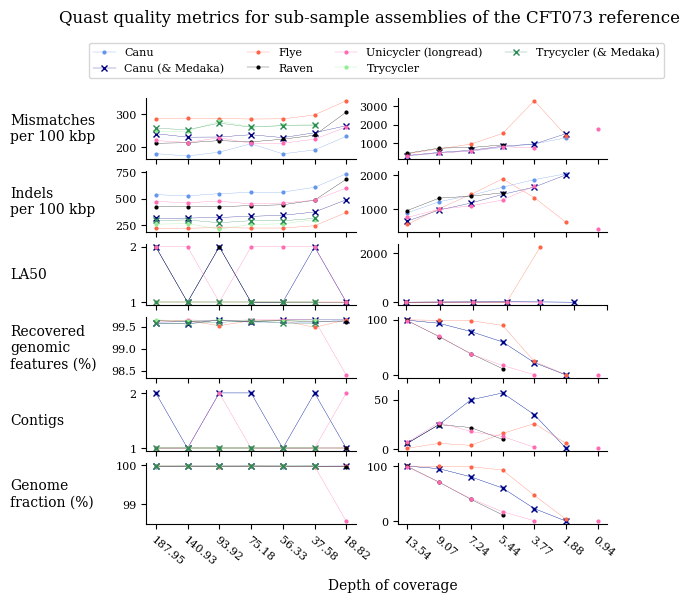

In [13]:
covs1 = [ "200X", "150X", "100X", "80X", "60X", "40X", "20X" ]
dfs1 = { }
for cov in covs1 :
    dfs1[ cov ] = pd.read_csv(open('./results/quast/CFT073~' + cov + '/report.tsv'), delimiter='\t')
    dfs1[ cov ].set_index("Assembly",inplace=True)
altXticks1 = [ 187.95, 140.93, 93.92, 75.18, 56.33, 37.58, 18.82 ]

covs2 = [ "15X", "10X", "8X", "6X", "4X", "2X", "1X" ]
dfs2 = { }
for cov in covs2 :
    dfs2[ cov ] = pd.read_csv(open('./results/quast/CFT073~' + cov + '/report.tsv'), delimiter='\t')
    dfs2[ cov ].set_index("Assembly",inplace=True)
altXticks2 = [ 13.54, 9.07, 7.24, 5.44, 3.77, 1.88, 0.94 ]

genomicFeatures = 5288

plotFeatures(
    features,
    [ "canu", "canu_medaka", "flye", "raven", "unicycler~longread", "trycycler", "trycycler_medaka" ],
    dfs1,
    dfs2,
    genomicFeatures,
    colors = colors,
    markers = markers,
    assemblerNames = assemblerNames,
    ylabels = ylabel,
    altXticks1 = altXticks1,
    altXticks2 = altXticks2,
    title = "Quast quality metrics for sub-sample assemblies of the CFT073 reference"
)

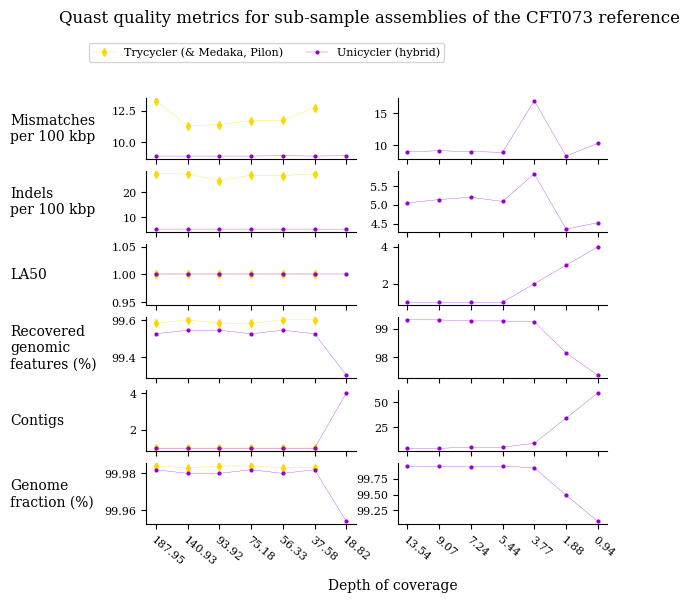

In [14]:
covs1 = [ "200X", "150X", "100X", "80X", "60X", "40X", "20X" ]
dfs1 = { }
for cov in covs1 :
    dfs1[ cov ] = pd.read_csv(open('./results/quast/CFT073~' + cov + '/report.tsv'), delimiter='\t')
    dfs1[ cov ].set_index("Assembly",inplace=True)
altXticks1 = [ 187.95, 140.93, 93.92, 75.18, 56.33, 37.58, 18.82 ]

covs2 = [ "15X", "10X", "8X", "6X", "4X", "2X", "1X" ]
dfs2 = { }
for cov in covs2 :
    dfs2[ cov ] = pd.read_csv(open('./results/quast/CFT073~' + cov + '/report.tsv'), delimiter='\t')
    dfs2[ cov ].set_index("Assembly",inplace=True)
altXticks2 = [ 13.54, 9.07, 7.24, 5.44, 3.77, 1.88, 0.94 ]

genomicFeatures = 5288

plotFeatures(
    features,
    [ "trycycler_medaka_pilon", "unicycler~hybrid" ],
    dfs1,
    dfs2,
    genomicFeatures,
    colors = colors,
    markers = markers,
    assemblerNames = assemblerNames,
    ylabels = ylabel,
    altXticks1 = altXticks1,
    altXticks2 = altXticks2,
    title = "Quast quality metrics for sub-sample assemblies of the CFT073 reference"
)